In [25]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np

def load_data(filepath):
    # Load the dataset
    data = pd.read_csv(filepath)
    
    # Print all column names to verify the label column
    print("Columns in the dataset:", data.columns.tolist())
    
    # Identify sequence ID features and additional features
    seq_id_features = [col for col in data.columns if col.startswith('SeqId_')]
    additional_features = ['age', 'proteinuria_log', 'eGFR_CKDEPI2021', 'race']  # Specify additional feature names
    features = seq_id_features + additional_features  # Combine sequence ID and additional features
    
    # Verify the correct label column name and update it here
    label_column = 'GDvsTI'  # Change 'GDvsTi' to the correct label column name as per the printed columns
    
    # Check if the label column exists, if not, raise an error to catch it during debugging
    if label_column not in data.columns:
        raise ValueError(f"Label column '{label_column}' not found in the dataset.")
    
    # Filter the dataset for the selected features and label
    filtered_data = data[features + [label_column]]  # Include the label column for filtering

    # Check for missing values in the features
    if filtered_data[features].isnull().values.any():
        # Impute missing values using the mean for continuous features
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        filtered_data[features] = imputer.fit_transform(filtered_data[features])
    
    # Check for missing values in the label column and raise an error if any
    if filtered_data[label_column].isnull().any():
        raise ValueError(f"Label column '{label_column}' contains NaN values.")
    
    filtered_data['GDvsTI'] = data['GDvsTI'].map({1: 0, 2: 1})
    
    
    return filtered_data, seq_id_features, additional_features

# Load data using the corrected function and pass the correct path to the CSV file
data, seq_id_features, additional_features = load_data('./data/Newkidney_data_final10.25.23.csv')



Columns in the dataset: ['samples', 'SeqId_10000_28', 'SeqId_10001_7', 'SeqId_10003_15', 'SeqId_10006_25', 'SeqId_10008_43', 'SeqId_10010_10', 'SeqId_10011_65', 'SeqId_10012_5', 'SeqId_10014_31', 'SeqId_10015_119', 'SeqId_10022_207', 'SeqId_10023_32', 'SeqId_10024_44', 'SeqId_10025_1', 'SeqId_10030_8', 'SeqId_10035_6', 'SeqId_10036_201', 'SeqId_10037_98', 'SeqId_10039_32', 'SeqId_10040_63', 'SeqId_10041_3', 'SeqId_10042_8', 'SeqId_10043_31', 'SeqId_10045_47', 'SeqId_10046_55', 'SeqId_10047_12', 'SeqId_10049_112', 'SeqId_10053_5', 'SeqId_10054_3', 'SeqId_10056_5', 'SeqId_10058_1', 'SeqId_10063_10', 'SeqId_10064_12', 'SeqId_10069_2', 'SeqId_10070_22', 'SeqId_10073_22', 'SeqId_10074_128', 'SeqId_10076_1', 'SeqId_10078_5', 'SeqId_10081_17', 'SeqId_10082_251', 'SeqId_10085_25', 'SeqId_10086_39', 'SeqId_10087_10', 'SeqId_10089_7', 'SeqId_10339_48', 'SeqId_10344_334', 'SeqId_10346_5', 'SeqId_10351_51', 'SeqId_10354_57', 'SeqId_10356_21', 'SeqId_10361_25', 'SeqId_10362_35', 'SeqId_10363_13', '


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score

def bootstrap_resample(y_test, y_proba, n_iterations=1000):
    bootstrapped_scores = []
    for _ in range(n_iterations):
        # Sample the true and predicted probabilities with replacement
        boot_true, boot_pred = resample(y_test, y_proba)
        # Calculate and store the score
        score = roc_auc_score(boot_true, boot_pred)
        bootstrapped_scores.append(score)
    return bootstrapped_scores


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

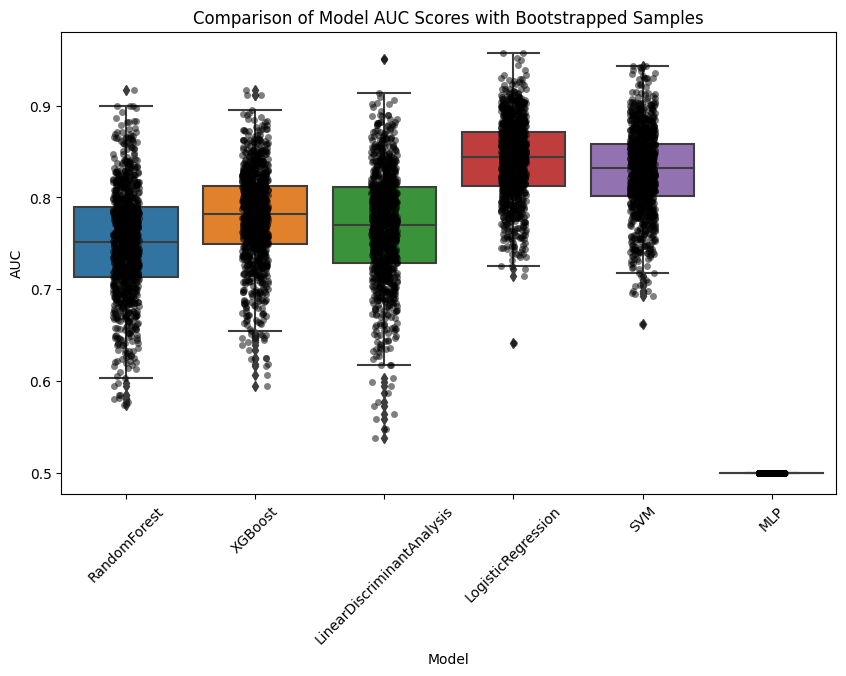

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Define the models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'MLP': MLPClassifier(random_state=42)
}

# Function to train models and evaluate performance
def train_and_evaluate_models(X, y):
    # Split the data into training and testing sets (60/40 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)
    
    results = {}
    
    # Train and predict with each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # If the model has a predict_proba method, use it to get probabilities
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            # For SVM and others that do not have predict_proba, use decision function
            y_proba = model.decision_function(X_test)
            # Normalize the decision function output to get probability-like values
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        mcc = matthews_corrcoef(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_proba)
        
        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc,
            'roc_auc': auc_score
        }
    
    return results, models, X_train, y_train, X_test, y_test


# Prepare the data
# Replace 'data', 'seq_id_features', 'additional_features', and 'GDvsTI' with your actual data and column names
X = data[seq_id_features + additional_features]  # Features
y = data['GDvsTI']  # Labels

results, models, X_train, y_train, X_test, y_test = train_and_evaluate_models(X, y)

# Bootstrap resampling and plotting
data_for_plotting = []
for model_name, model in models.items():
    # Get the test probabilities and true values
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    
    # Bootstrap resampling
    bootstrapped_auc_scores = bootstrap_resample(y_test, y_proba)
    
    # Add to data for plotting
    for score in bootstrapped_auc_scores:
        data_for_plotting.append({'Model': model_name, 'Metric': 'AUC', 'Score': score})

df_results = pd.DataFrame(data_for_plotting)

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Draw a strip plot to show the bootstrapped sample dots
sns.stripplot(x="Model", y="Score", data=df_results, color="black", alpha=0.5, jitter=True)

# Draw a box plot to show AUC distributions
sns.boxplot(x="Model", y="Score", data=df_results)

plt.xticks(rotation=45) 
plt.xticks(fontsize=10)

# Set plot labels and titles
plt.title('Comparison of Model AUC Scores with Bootstrapped Samples')
plt.xlabel('Model')
plt.ylabel('AUC')

# Show the plot
plt.show()


ValueError: Could not interpret input 'Model'

<Figure size 1000x600 with 0 Axes>

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


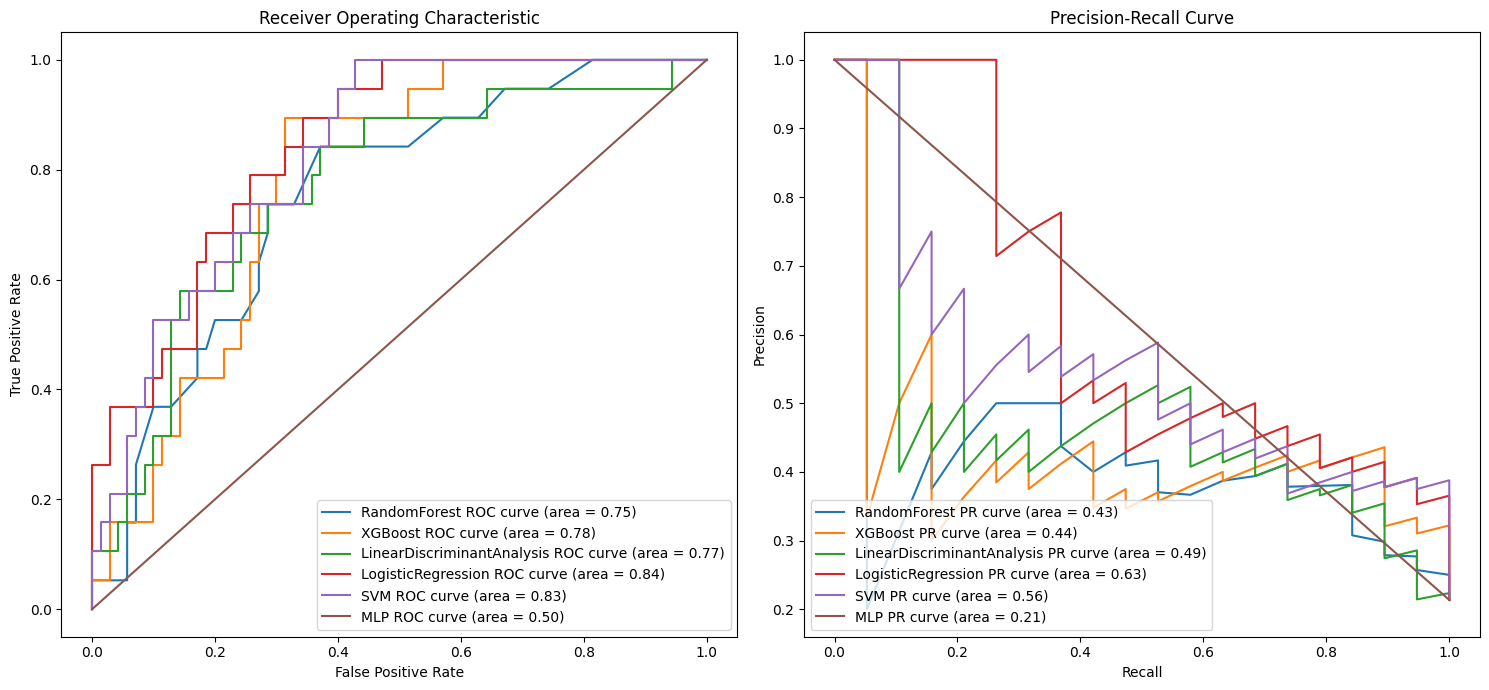

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Plot ROC and PR curves
def plot_curves(models, X_test, y_test):
    plt.figure(figsize=(15, 7))
    for name, model in models.items():
        # ROC Curve
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        # PR Curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)
        
        # Plotting
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, label=f'{name} ROC curve (area = {roc_auc:.2f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, label=f'{name} PR curve (area = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

# Plot the curves
plot_curves(models, X_test, y_test)


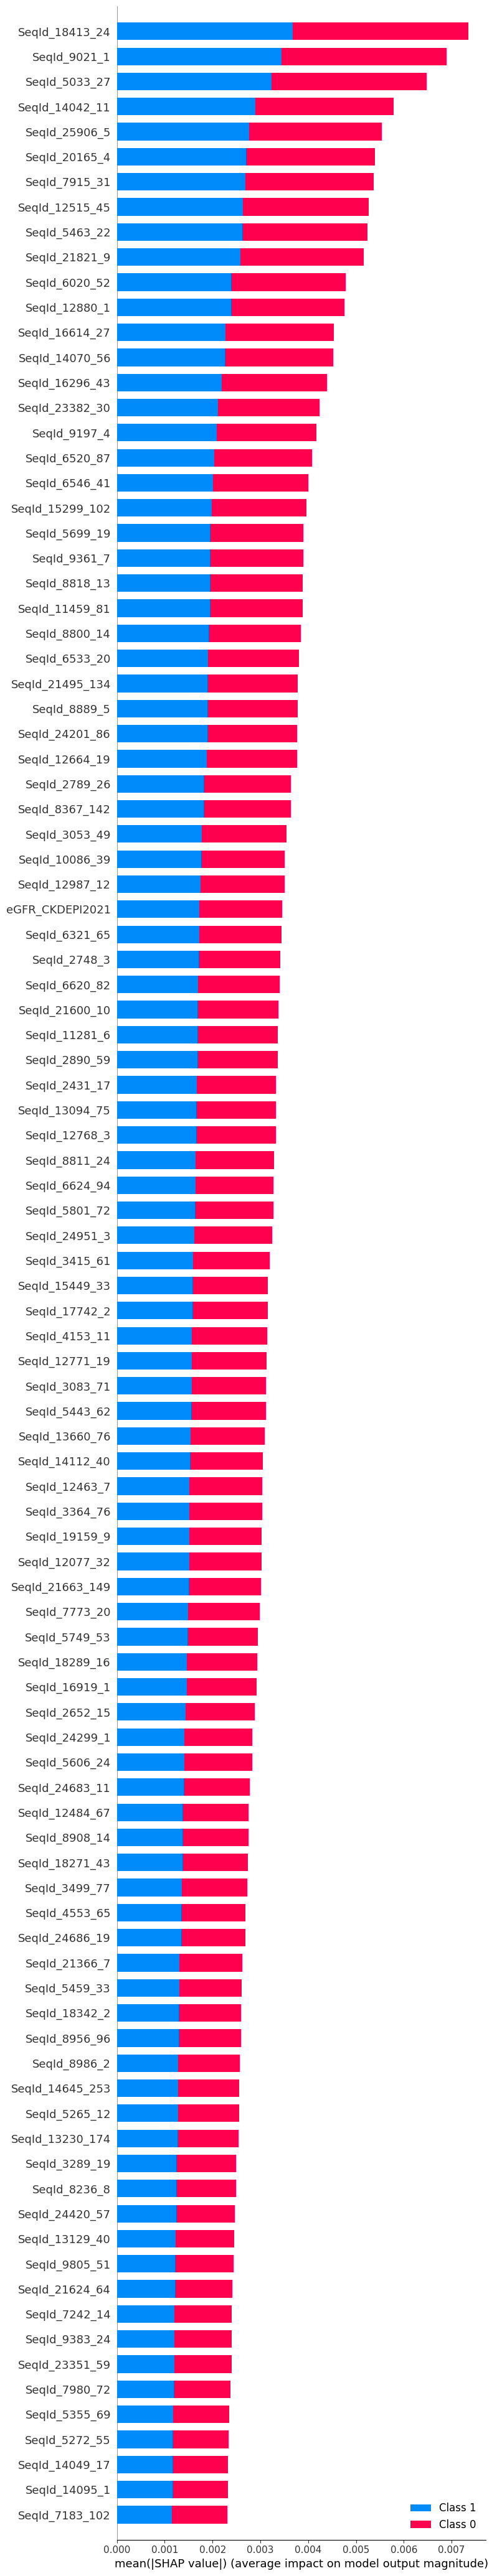

In [31]:
import shap
def shap_analysis(model, X):
    # Use TreeExplainer for tree-based models like RandomForest
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # Summarize the SHAP values for the top ten features
    shap.summary_plot(shap_values, X, plot_type="bar", max_display=100, feature_names=X.columns)


# Assuming the best model from the previous evaluation is RandomForest
best_model = models['RandomForest']

# Call shap_analysis with the correct data
shap_analysis(best_model, X_train)  # Use X_train here instead of X_test
